In [2]:
%matplotlib inline
from collections import namedtuple
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import scipy.stats as stats
from scipy.interpolate import interp1d
import scipy
import statsmodels.api as sm
from scipy import signal
from numpy.fft import fft, ifft, ifftshift


bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

Convolving the terms in the PL relation to see the metallicity effect
==========================================================
ipython notebook adapted from https://github.com/timstaley/ipython-notebooks/blob/master/probabilistic_programming/convolving_distributions_illustration.ipynb

Suppose we want to model a random variate $Y$, such that
$$Y = X + E$$ 
where $X$ is some random variate of interest, and $E$ represents an additive error term.

This is essentially the same as the PL relation:

We have the square distribution, with gaussian photometric uncertainties, and a (I'm assuming) gaussian metallicity term.

The probability density function of the resulting PL relation is described by the convolution of these terms:

$$PL(IS, obs, Z) = P(IS)*P(obs)*P(Z)$$

Where $$P(IS)$$ is the intrinsic PDF of the instability strip, $$P(obs)$$ is the PDF of the gaussian uncertainties, and $$P(Z)$$ is the PDF of the metallicity term.



Convolution of the PDFs 
-----------------------

Here I'm using the fft convolution from scipy
http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve
I don't know whether it's any better than the regular convolution package, I think the example script just used FFT because it's faster. If you're interested the script I forked this one from goes into detail about performance issues in scipy's convolution algorithms, but I deleted it all from this because meh.



Grid length, sum(gauss_pmf), sum(uni_pmf),sum(conv_pmf):
10000 1.0 1.0004655379 1.0004655379


(<matplotlib.legend.Legend at 0x109148550>,
 <matplotlib.text.Text at 0x1092f1d50>)

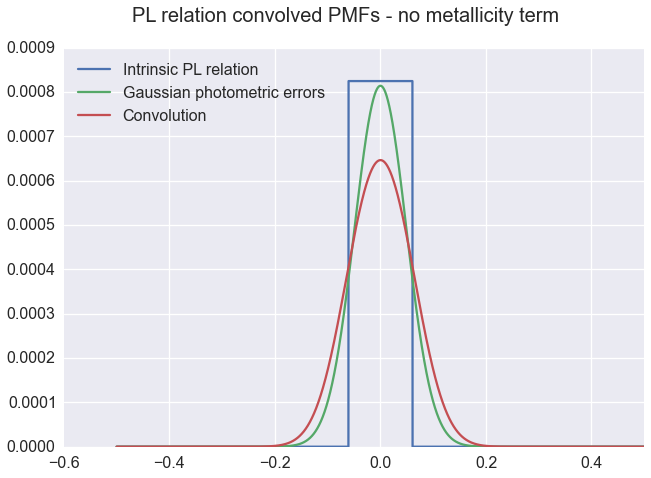

In [3]:
full_width_of_PL = np.sqrt(12.)*0.035
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
errscale = 0.049
photometric = stats.norm(loc=0,scale=errscale)

## I'm not including a metallicity term at this point, becuase we haven't worked it out yet.

# NB Kernel support array **MUST** be symmetric about centre of the kernel (error PDF) for this to work right. 
# Support also needs to extend about any significant areas of the component PDFs.
# Here, we just define one massive support for both input PDF, and error PDF (kernel)
# But we can do much better (see later)

#NB step-size determines precision of approximation
delta = 1e-4
big_grid = np.arange(-.5,.5,delta)

# Cannot analytically convolve continuous PDFs, in general.
# So we now make a probability mass function on a fine grid 
# - a discrete approximation to the PDF, amenable to FFT...
pmf1 = intrinsic.pdf(big_grid)*delta
pmf2 = photometric.pdf(big_grid)*delta
conv_pmf = scipy.signal.fftconvolve(pmf1,pmf2,'same') # Convolved probability mass function
print "Grid length, sum(gauss_pmf), sum(uni_pmf),sum(conv_pmf):"
print len(big_grid), sum(photometric.pdf(big_grid)*delta), sum(intrinsic.pdf(big_grid)*delta), sum(conv_pmf)
conv_pmf = conv_pmf/sum(conv_pmf)

plt.plot(big_grid,pmf1, label='Intrinsic PL relation')
plt.plot(big_grid,pmf2, label='Gaussian photometric errors')
plt.plot(big_grid,conv_pmf, label='Convolution')
plt.xlim(-0.6,max(big_grid))
plt.legend(loc='best'), plt.suptitle('PL relation convolved PMFs - no metallicity term')

Just by adding the photometric uncertainties to this PL, we're seeing it look more like a gaussian.

Estimation of the metallicity term
===================

To estimate the metalliticity term, we need to go backwards, like we were doing yesterday with the uncertainties. We were almost right with the uncertainties in quadrature thing, but I think this is the right way to do it. We start with the *observed* distribution, and deconvolve the things we know, to get the metallicity term out.

Deconvolution of the PDFs
------------------------

To deconvolve the different parts, we have to do it one part at a time using scipy:

http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.deconvolve.html#scipy.signal.deconvolve

[//]: # ( In markdown, use 3 backticks to for code hightlighting)
[//]: # (Also this is how you do a comment. Different to everything else. Who knew!)

```python
from scipy import signal
original = [0, 1, 0, 0, 1, 1, 0, 0]
impulse_response = [2, 1]
recorded = signal.convolve(impulse_response, original)
recorded
array([0, 2, 1, 0, 2, 3, 1, 0, 0])
recovered, remainder = signal.deconvolve(recorded, impulse_response)
recovered
array([ 0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.])
```

In our case, we would run deconvolve on the observed PL to remove the intrinsic PL signal. Then we would re-run deconvolve on 'recovered' ('remainder' would be the intrinsic PL) to remove the gaussian uncertainties. All that would be left in 'recovered' at that point should be the signal from the metallicity term.

The plot you sent last night showed that the residuals looked like a gaussian, so we'll estimate the observed PL relation as a gaussian.

[  1.11478611e-11   1.12264454e-11   1.13055678e-11 ...,   1.13852319e-11
   1.13055678e-11   1.12264454e-11] [ 0.  0.  0. ...,  0.  0.  0.] [  1.99816151e-26   2.04020457e-26   2.08312359e-26 ...,   2.12693662e-26
   2.08312359e-26   2.04020457e-26]
10000 10000 10000


(<matplotlib.legend.Legend at 0x10963ded0>,
 <matplotlib.text.Text at 0x10a72d3d0>)

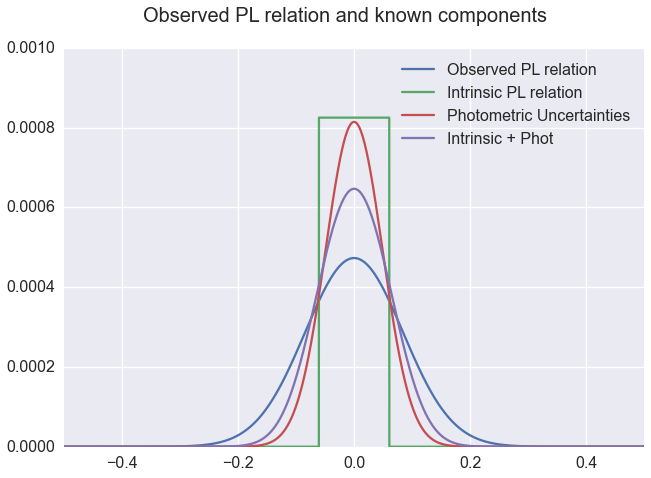

In [4]:
full_width_of_PL = np.sqrt(12.)*0.035
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
errscale = 0.049
photometric = stats.norm(loc=0,scale=errscale)

observed_PL_1sigma = 0.0843634290098
observed_PL_relation = stats.norm(loc=0,scale=observed_PL_1sigma)

#NB step-size determines precision of approximation
delta = 1e-4
big_grid = np.arange(-.5,.5,delta)


## Setting up the PDFs and PMFs for the components
pmf_o = observed_PL_relation.pdf(big_grid)*delta
pmf_i = intrinsic.pdf(big_grid)*delta
pmf_p = photometric.pdf(big_grid)*delta

print pmf_o, pmf_i, pmf_p
print len(pmf_o), len(pmf_i), len(pmf_p)

conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')
conv_pmf = conv_pmf/sum(conv_pmf)

plt.plot(big_grid,pmf_o, label='Observed PL relation')
plt.plot(big_grid,pmf_i, label='Intrinsic PL relation')
plt.plot(big_grid,pmf_p, label='Photometric Uncertainties')
plt.plot(big_grid, conv_pmf, label='Intrinsic + Phot')
plt.xlim(min(big_grid),max(big_grid))
plt.ylim(0,0.001)
plt.legend(loc='best'), plt.suptitle('Observed PL relation and known components')



I've corrected the convolution code above, and there **is** a difference between the convolution of the intrinsic + photometric distributions and the observed PL --> There is a missing term that needs to be accounted for.

I've been trying to get the deconvolution stuff to work all day, and I can't do it. So we're going old school. Brute force all the way.

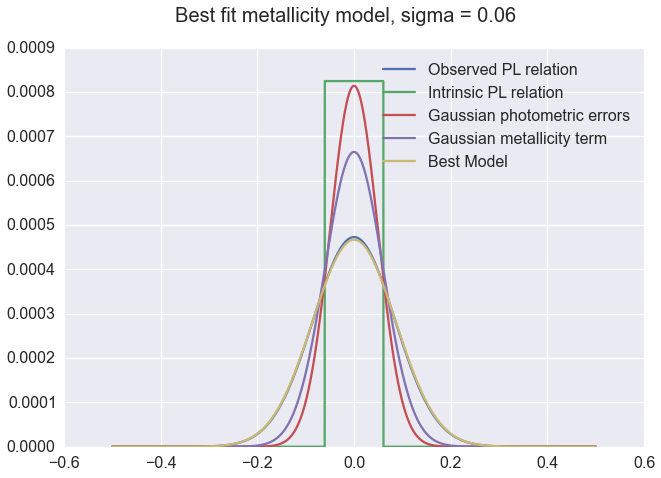

In [5]:
## Deconvolution is hard.

## Can I brute force this??

#First convolve the intrinsic PL and the photometric errors. This will be the same every time
conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')

difference_min = 10000000

# Then iterate over a range of values for the uncertainty introduced by metallicity
for metals in np.arange(0, 0.1, 0.01):
    metallicity = stats.norm(loc=0,scale=metals)
    pmf_m = metallicity.pdf(big_grid)*delta
    metallicity_convolved = scipy.signal.fftconvolve(conv_pmf, pmf_m, 'same')
    metallicity_convolved = metallicity_convolved/sum(metallicity_convolved)

    ## Check how different this is from the observed PL
    ## I tried using the ratio of the convoltion and the observed PL, but that was shit.
    ## What about the absolute difference?
    difference = sum(abs(metallicity_convolved - pmf_o))
    if difference < difference_min:
        difference_min = difference
        best_metallicity = metals
        best_metallicity_pmf = pmf_m
        best_convolved = metallicity_convolved

plt.plot(big_grid,pmf_o, label='Observed PL relation')
plt.plot(big_grid,pmf_i, label='Intrinsic PL relation')
plt.plot(big_grid,pmf_p, label='Gaussian photometric errors')
plt.plot(big_grid,best_metallicity_pmf, label="Gaussian metallicity term")
plt.plot(big_grid, best_convolved, label="Best Model")


title_text = 'Best fit metallicity model, sigma = ' + str(best_metallicity)
plt.legend(loc='best'), plt.suptitle(title_text)
plt.savefig('metal_model.pdf')


    

** I AM A GENIUS**
==============


Estimation of the upper limit of the metallicity term, by convolution of probability density functions:
-------------------------------------------------------------------------------------------------
* We observe the $\omega$ Cen PL relation to have a dispersion of $\sigma_{obs} = 0.084$
* Assume that the intrinsic PL relation is a uniform distribution with $\sigma_{int} = 0.35$ (M4, [3.6], RRab)
* Assume the photometric uncertainties are distributed gaussianly (totally a word) with $\sigma_{phot} = 0.049$
* Assuming that all the rest of the dispersion in the *observed* PL relation is due to the metallicity spread of $\omega$ Cen, and that the metallicities are distributed gausiannly around the mean metallicity:

$$P(obs) = P(int) * P(phot) * P(metal)$$

* Tested all values of $\sigma_{metal}$ between 0 and 0.1, with a step size of 0.01. Best fit value for [3.6] RRab's is $\sigma_{metal} = 0.06$ mag. 

** TO DO ** Meredith - Do you want to do these??
* Is the shape of the metallicity distribution reasonable? 
 - Do we need to be using a skewed gaussian or something?
 - Can we match the observed metallicity distribution somehow?
* Shape of the osbserved PL residuals for [4.5] were not gaussian
 - What function should we use for that??
 - Same as for metallicity - should it be a skewed distribution?
* Estimation of uncertainties 
 - Can also do this by brute force
 - How much do you need to change $\sigma_{metal} to change the difference by 1 sigma??
* Calculate this result for the other bands and other RRL types
* Compare between bands and types